In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os, cv2
from tqdm import tqdm
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

#### 이미지 확인

evee
fish
isang
jamman


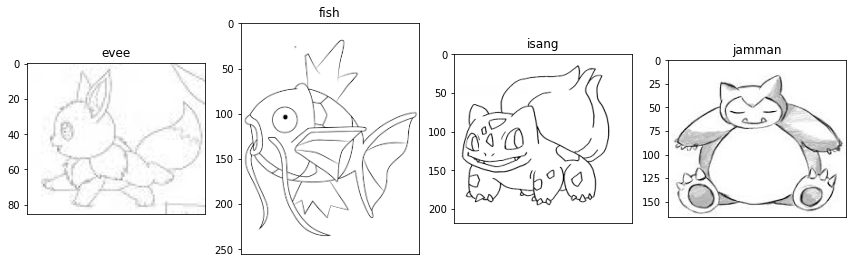

In [27]:
img_path = "C:/workspace/04.SecondProject/images/line"
plt.figure(figsize=(30,5))
for num, i in enumerate(os.listdir(img_path)):
    char = i
    print(char)
    img_src = cv2.imread(f"{img_path}/{char}/{char} (1).jpg", cv2.IMREAD_COLOR)
    plt.subplot(1, len(os.listdir(img_path)), num+1)
    plt.title(char), plt.xticks([])
    plt.imshow(img_src);
    if num == 3:
        break

#### 데이터 색 변화 없이 학습

loss: 1.0884 - accuracy: 0.6825

In [3]:
img_path = "C:/workspace/04.SecondProject/images/line"
cha_list = os.listdir(img_path)
X = []
y = []
err = []

for idx, img_cha in enumerate(tqdm(cha_list)):
    filepath = f"{img_path}/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        try:
            resize_img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)
            X.append(resize_img / 256)
            y.append(idx)
        except:
            err.append(fname)
            continue
        
X = np.array(X)
y = np.array(y)
print('\n에러:','None' if len(err) == 0 else err)

100%|██████████| 8/8 [00:01<00:00,  4.22it/s]


에러: ['pikachu (117).jpg', 'pikachu (134).jpg', 'pikachu (135).jpg', 'pikachu (26).jpg', 'pikachu (45).jpg', 'pikachu (85).jpg', 'squirtle (107).jpg', 'squirtle (110).jpg', 'squirtle (58).jpg']


In [4]:
X.shape, y.shape

((1053, 128, 128, 3), (1053,))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((842, 128, 128, 3), (211, 128, 128, 3), (842,), (211,))

In [6]:
# y_data: one-hot encoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((842, 8), (211, 8))

In [7]:
with tf.device("/device:CPU:0"):
    model = Sequential([
    Conv2D(32, (3, 3), input_shape = (128,128,3), padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0

In [8]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = './line_adam.h5'
mc = ModelCheckpoint(model_path, moniter = 'val_loss', verbose = 0, save_best_only = True)
es = EarlyStopping(patience = 50)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,          # randomly rotate images in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally 
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.1,            # 도형의 기울기
    zoom_range=[0.8,1.2],       # 0.8~1.2 배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)
datagen.fit(X_train)

In [11]:
with tf.device("/device:GPU:0"):
    hist1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32), verbose=0,
    validation_data=(X_valid, Y_valid), epochs = 1000, callbacks=[mc, es]
    )

In [12]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 26ms/step - loss: 0.9652 - accuracy: 0.8104


[0.9651699066162109, 0.8104265332221985]

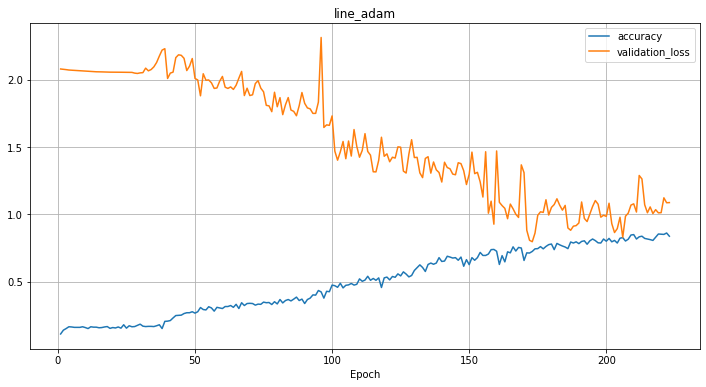

In [13]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('line_adam')
plt.legend(), plt.grid()
plt.show()

#### 그레이 색상 변경 후

loss: 2.0550 - accuracy: 0.1611

In [50]:
img_path = "C:/workspace/04.SecondProject/images/line"
cha_list = os.listdir(img_path)
X = []
y = []
err = []

for idx, img_cha in enumerate(tqdm(cha_list)):
    filepath = f"{img_path}/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resize_img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)
            X.append(resize_img / 256)
            y.append(idx)
        except:
            err.append(fname)
            continue
        
X = np.array(X)
y = np.array(y)
print('\n에러:','None' if len(err) == 0 else err)

100%|██████████| 8/8 [00:01<00:00,  4.25it/s]


에러: ['pikachu (117).jpg', 'pikachu (134).jpg', 'pikachu (135).jpg', 'pikachu (26).jpg', 'pikachu (45).jpg', 'pikachu (85).jpg', 'squirtle (107).jpg', 'squirtle (110).jpg', 'squirtle (58).jpg']


In [51]:
X.shape, y.shape

((1053, 128, 128), (1053,))

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((842, 128, 128), (211, 128, 128), (842,), (211,))

In [53]:
X_train = X_train.reshape(-1, 128, 128, 1) / 255.
X_test = X_test.reshape(-1, 128, 128, 1) / 255.
X_train.shape, X_test.shape

((842, 128, 128, 1), (211, 128, 128, 1))

In [54]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((842, 8), (211, 8))

In [55]:
with tf.device("/device:CPU:0"):
    model = Sequential([
    Conv2D(32, (3, 3), input_shape = (128,128,1), padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation = 'softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 31, 64)       

In [56]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = './line_gray_adam.h5'
mc = ModelCheckpoint(model_path, moniter = 'val_loss', verbose = 0, save_best_only = True)
es = EarlyStopping(patience = 15)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,          # randomly rotate images in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally 
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.1,            # 도형의 기울기
    zoom_range=[0.8,1.2],       # 0.8~1.2 배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)
datagen.fit(X_train)

In [60]:
with tf.device("/device:GPU:0"):
    hist1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32), verbose=0,
    validation_data=(X_valid, Y_valid), epochs = 200, callbacks=[mc, es]
    )

In [61]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 11ms/step - loss: 2.0550 - accuracy: 0.1611


[2.0549542903900146, 0.1611374467611313]

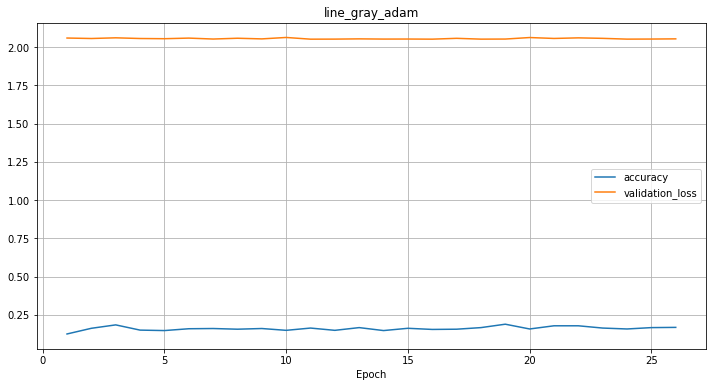

In [63]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('line_gray_adam')
plt.legend(), plt.grid()
plt.show()

#### 그레이, 다른 모델링

- loss: 2.0550 - accuracy: 0.1611

In [4]:
img_path = "C:/workspace/04.SecondProject/images/line"
cha_list = os.listdir(img_path)
X = []
y = []
err = []

for idx, img_cha in enumerate(tqdm(cha_list)):
    filepath = f"{img_path}/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resize_img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)
            X.append(resize_img / 256)
            y.append(idx)
        except:
            err.append(fname)
            continue
        
X = np.array(X)
y = np.array(y)
print('\n에러:','None' if len(err) == 0 else err)

100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


에러: ['pikachu (117).jpg', 'pikachu (134).jpg', 'pikachu (135).jpg', 'pikachu (26).jpg', 'pikachu (45).jpg', 'pikachu (85).jpg', 'squirtle (107).jpg', 'squirtle (110).jpg', 'squirtle (58).jpg']


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = seed
)
X_train = X_train.reshape(-1, 128, 128, 1) / 255.
X_test = X_test.reshape(-1, 128, 128, 1) / 255.

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [6]:
with tf.device("/device:CPU:0"):
    model = Sequential([
    Conv2D(32, (3, 3), input_shape = (128,128,1), padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0

In [7]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = './line_gray_rms.h5'
mc = ModelCheckpoint(model_path, moniter = 'val_loss', verbose = 0, save_best_only = True)
es = EarlyStopping(patience = 15)

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,   # set input mean to 0 over the dataset
    samplewise_center=False,    # set each sample mean to 0
    featurewise_std_normalization=False,    # divide inputs by std of dataset
    samplewise_std_normalization=False,     # divide each input by its std
    zca_whitening=False,    # apply ZCA whitening
    zca_epsilon=1e-06,      # epsilon for ZCA whitening
    rotation_range=0,       # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically
    shear_range=0.,         # set range for random shear
    zoom_range=0.1,         # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    fill_mode='nearest',    # set mode for filling points outside the input boundaries
    cval=0.,                # value used for fill_mode = "constant"
    horizontal_flip=True,   # randomly flip images
    vertical_flip=False,    # randomly flip images
    rescale=None,           # set rescaling factor (applied before any other transformation)
    preprocessing_function=None,    # set function that will be applied on each input
    data_format=None,       # image data format, either "channels_first" or "channels_last"
    validation_split=0.0    # fraction of images reserved for validation
)
datagen.fit(X_train)

In [8]:
with tf.device("/device:GPU:0"):
    hist1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=16), verbose=0,
    validation_data=(X_valid, Y_valid), epochs = 200, callbacks=[mc, es]
    )
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 26ms/step - loss: 2.0550 - accuracy: 0.1611


[2.055028200149536, 0.1611374467611313]

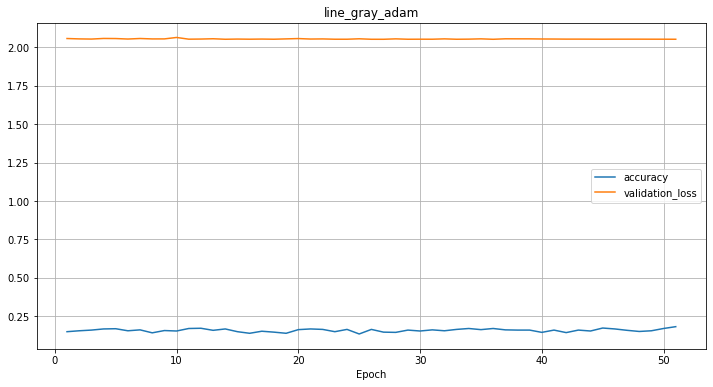

In [9]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('line_gray_adam')
plt.legend(), plt.grid()
plt.show()

#### 3차원, rms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os, cv2
from tqdm import tqdm
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


moniter = "val_accuracy"  #accuracy


In [2]:
img_path = "C:/workspace/04.SecondProject/images/line"
cha_list = os.listdir(img_path)
X = []
y = []
err = []

for idx, img_cha in enumerate(tqdm(cha_list)):
    filepath = f"{img_path}/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        try:
            resize_img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)
            X.append(resize_img / 256)
            y.append(idx)
        except:
            err.append(fname)
            continue
        
X = np.array(X)
y = np.array(y)
print('\n에러:','None' if len(err) == 0 else err)

100%|██████████| 8/8 [00:01<00:00,  4.37it/s]


에러: ['pikachu (117).jpg', 'pikachu (134).jpg', 'pikachu (135).jpg', 'pikachu (26).jpg', 'pikachu (45).jpg', 'pikachu (85).jpg', 'squirtle (107).jpg', 'squirtle (110).jpg', 'squirtle (58).jpg']


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = seed
)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,   # set input mean to 0 over the dataset
    samplewise_center=False,    # set each sample mean to 0
    featurewise_std_normalization=False,    # divide inputs by std of dataset
    samplewise_std_normalization=False,     # divide each input by its std
    zca_whitening=False,    # apply ZCA whitening
    zca_epsilon=1e-06,      # epsilon for ZCA whitening
    rotation_range=0,       # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically
    shear_range=0.,         # set range for random shear
    zoom_range=0.1,         # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    fill_mode='nearest',    # set mode for filling points outside the input boundaries
    cval=0.,                # value used for fill_mode = "constant"
    horizontal_flip=True,   # randomly flip images
    vertical_flip=False,    # randomly flip images
    rescale=None,           # set rescaling factor (applied before any other transformation)
    preprocessing_function=None,    # set function that will be applied on each input
    data_format=None,       # image data format, either "channels_first" or "channels_last"
    validation_split=0.0    # fraction of images reserved for validation
)
datagen.fit(X_train)

In [5]:
with tf.device("/device:CPU:0"):
    model = Sequential([
    Conv2D(32, (3, 3), input_shape = (128,128,3), padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation = 'softmax')
])

In [6]:

model.compile(
    optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),
    loss='categorical_crossentropy', metrics=['accuracy']
)

model_path = './line_rms.h5'
mc = ModelCheckpoint(model_path, moniter = moniter, verbose = 0, save_best_only = True)
es = EarlyStopping(patience = 30)

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)



In [7]:
with tf.device("/device:GPU:0"):
    hist1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=16), verbose=0,
    validation_data=(X_valid, Y_valid), epochs = 500, callbacks=[mc, es]
    )
    best_model = load_model(model_path)
    best_model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 51ms/step - loss: 0.7912 - accuracy: 0.7820


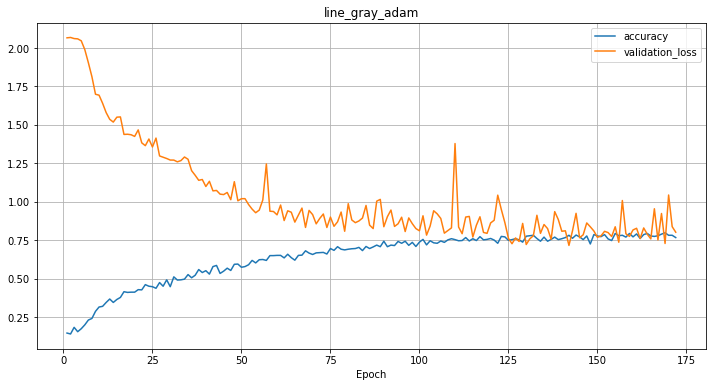

In [8]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('line_gray_adam')
plt.legend(), plt.grid()
plt.show()

#### 3차원, SGD

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os, cv2
from tqdm import tqdm
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


moniter = "val_loss"  #accuracy

In [ ]:
img_path = "C:/workspace/04.SecondProject/images/line"
cha_list = os.listdir(img_path)
X = []
y = []
err = []

for idx, img_cha in enumerate(tqdm(cha_list)):
    filepath = f"{img_path}/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        try:
            resize_img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)
            X.append(resize_img / 256)
            y.append(idx)
        except:
            err.append(fname)
            continue
        
X = np.array(X)
y = np.array(y)
print('\n에러:','None' if len(err) == 0 else err)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = seed
)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
with tf.device("/device:CPU:0"):
    model = Sequential([
    Conv2D(32, (3, 3), input_shape = (128,128,3), padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation = 'softmax')
])
model.compile('SGD', 'categorical_crossentropy', ['accuracy'])

model_path = './line_SGD.h5'
mc = ModelCheckpoint(model_path, moniter = moniter, verbose = 0, save_best_only = True)
es = EarlyStopping(patience = 30)

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,   # set input mean to 0 over the dataset
    samplewise_center=False,    # set each sample mean to 0
    featurewise_std_normalization=False,    # divide inputs by std of dataset
    samplewise_std_normalization=False,     # divide each input by its std
    zca_whitening=False,    # apply ZCA whitening
    zca_epsilon=1e-06,      # epsilon for ZCA whitening
    rotation_range=0,       # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically
    shear_range=0.,         # set range for random shear
    zoom_range=0.1,         # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    fill_mode='nearest',    # set mode for filling points outside the input boundaries
    cval=0.,                # value used for fill_mode = "constant"
    horizontal_flip=True,   # randomly flip images
    vertical_flip=False,    # randomly flip images
    rescale=None,           # set rescaling factor (applied before any other transformation)
    preprocessing_function=None,    # set function that will be applied on each input
    data_format=None,       # image data format, either "channels_first" or "channels_last"
    validation_split=0.0    # fraction of images reserved for validation
)
datagen.fit(X_train)

In [ ]:
with tf.device("/device:GPU:0"):
    hist1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=16), verbose=0,
    validation_data=(X_valid, Y_valid), epochs = 500, callbacks=[mc, es]
    )
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

In [ ]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('line_SGD')
plt.legend(), plt.grid()
plt.show()